In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import plotly.offline as py
from plotly.offline import iplot,init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True)

import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline  
cf.go_offline()  
cf.set_config_file(offline=False, world_readable=True)

from IPython.display import Markdown,HTML
import matplotlib.gridspec as gridspec # to do the grid of plots

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def bold(string):
    display(Markdown(string))

In [3]:
os.chdir("C:/Users/Sourav/Desktop/Data Sets")

In [4]:
netdata = pd.read_csv("netflix_titles.csv") 

In [5]:
netdata.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [6]:
netdata.shape

(6234, 12)

In [7]:
netdata["date_added"] = pd.to_datetime(netdata['date_added'])
netdata['year_added'] = netdata['date_added'].dt.year
netdata['month_added'] = netdata['date_added'].dt.month

netdata['season_count'] = netdata.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else "", axis = 1)
netdata['duration'] = netdata.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else "", axis = 1)
netdata['duration'] =netdata.apply(lambda x : '0' if x['duration']=='' else x['duration'],axis=1)
netdata['duration'] =  netdata['duration'].astype(float)

In [8]:
netdata.shape

(6234, 15)

In [11]:
temp = netdata['rating'].value_counts()
df = pd.DataFrame({'rating':temp.index,'values':temp.values})
df.iplot(kind='pie',labels='rating',values='values',title= 'Distribution of Ratings in data')

TV-14:
Programs rated TV-14 contains material that parents or adult guardians may find unsuitable for children under the age of 14.

TV-G:
Netflix has stamped them with an age certification of 'G', indicating they're appropriate for general audiences.

TV-Y:
A TV-Y rating means that programming is appropriate for children of all ages. TV-Y7 indicates that programming is designed for chil- dren ages 7 and older. An additional rating, TV-Y7-FV, is used to indicate that a program contains “fantasy violence” that may be more intense or combative than other TV-Y7 programs.

TV-MA:
"TV-MA" is a rating assigned by the TV Parental Guidelines to a television program that was designed for mature audiences only. Using this rating, the TVPG warns viewers that the show's content contains foul language, graphic violence, graphic sexual activity or any combination of these elements.

TV-PG:
TV-PG means that a show can be viewed by younger audiences but shouldn't be seen without their parents in the room

R:
R (restricted): No one under 17 admitted without an accompanying parent or guardian. This rating is given for frequent strong language and violence, nudity for sexual purposes, and drug abuse

NR- Not rated, UR- Unrated

NC-17:
An NC-17 rating means the content isn't suitable for children under 17 and younger. These are movies meant to be watched after your children have long since been tucked in and are sleeping in their beds. Netflix is streaming several NC-17 movies for the adults in your family to enjoy.

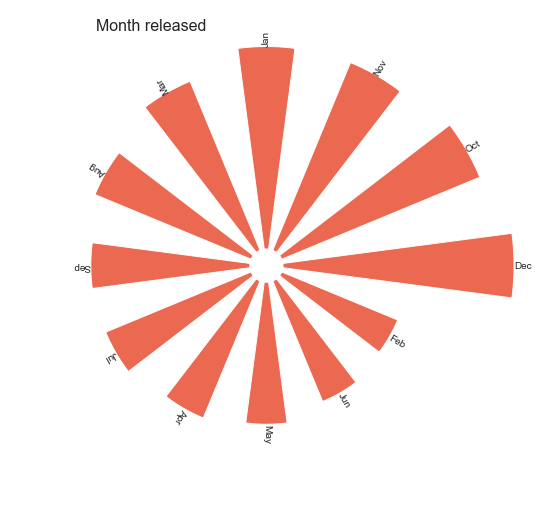

In [12]:
t = netdata['month_added'].value_counts()

lObjectsALLcnts = list(t.values)

lObjectsALLlbls = list(t.index)
mapp1 = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
lObjectsALLlbls = [mapp1[x] for x in lObjectsALLlbls]

iN = len(lObjectsALLcnts)
arrCnts = np.array(lObjectsALLcnts)


theta=np.arange(0, 2*np.pi, 2*np.pi/iN)
width = (2*np.pi)/iN *0.5
bottom = 50

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.2, 0.1, 1, 0.9], polar=True)
fig.suptitle('Month released', fontsize=16)
bars = ax.bar(theta, arrCnts, width=width, bottom=bottom, color='#eb6951')
plt.axis('off')

rotations = np.rad2deg(theta)
for x, bar, rotation, label in zip(theta, bars, rotations, lObjectsALLlbls):
    lab = ax.text(x,bottom+bar.get_height() , label, ha='left', va='center', rotation=rotation, rotation_mode="anchor",)   
plt.show()

In [14]:
df1 = netdata[netdata['type']=='TV Show']
df2 = netdata[netdata['type']=='Movie']

df1 = df1.groupby('date_added')["title"].nunique().sort_values()
df2 = df2.groupby('date_added')["title"].nunique().sort_values()

trace1 = go.Scatter(x=df1.index,y=df1.values,mode='markers',name='TV Shows')
trace2 = go.Scatter(x=df2.index,y=df2.values,mode='markers',name='Movies')

layout = go.Layout(template= "plotly_dark", title = 'TV Shows', xaxis = dict(title = 'Years'))
fig = go.Figure(data = [trace1,trace2], layout = layout)
fig.show()

In [15]:
pd.crosstab(netdata.type,netdata.year_added,margins=True).style.background_gradient(cmap='summer_r')

year_added,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,All
type,,,,,,,,,,,,,,
Movie,1,2,1,13,4,6,19,58,264,913,1290,1546,147,4264
TV Show,1,0,0,0,3,6,6,32,192,387,492,803,37,1959
All,2,2,1,13,7,12,25,90,456,1300,1782,2349,184,6223


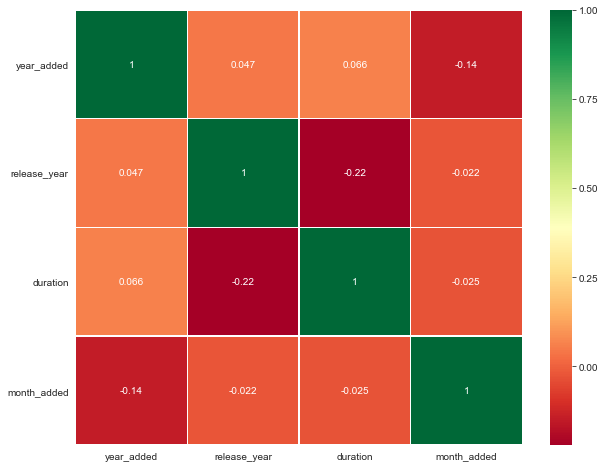

In [21]:
cols = ['country','type','year_added','season_count','release_year','rating','duration','month_added']
sns.heatmap(netdata[cols].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

There are basically three types of recommender systems:-

Demographic Filtering- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Content Based Filtering- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

Collaborative Filtering- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

In [22]:
#Filling nan values with empty string in director,country,cast
nanlist=['cast','director','country']
metalist=['cast','listed_in','director']

nancols=netdata[nanlist].fillna(' ')

netdata=netdata.drop(nanlist,axis=1)
filterdata=pd.concat([netdata,nancols],axis=1)

#Few processing
filterdata['cast']=filterdata['cast'].apply(lambda x: x.split(','))
filterdata['director']=filterdata['director'].apply(lambda x: x.split(','))
filterdata['country']=filterdata['country'].apply(lambda x: x.split(','))

In [23]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(filterdata['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(6234, 16151)

In [24]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
#Construct a reverse map of indices and movie titles
indices = pd.Series(filterdata.index, index=filterdata['title']).drop_duplicates()

In [25]:
def get_recommendations(title, cosine_sim=cosine_sim):
    
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return filterdata['title'].iloc[movie_indices]

In [30]:
get_recommendations('Breaking Bad')

3901                      Dismissed
3744                    Iron Ladies
6077                  Alexa & Katie
2806                The Five Venoms
5566    Ouran High School Host Club
4110               Taare Zameen Par
3107               Loving Annabelle
2416          Servant of the People
309                    Mr. Woodcock
3551                        Posesif
Name: title, dtype: object

In [34]:
get_recommendations("Ocean's Twelve")

814                        Ocean's Thirteen
2208                     Pizza, birra, faso
1398                         Ocean's Eleven
4220                            Rajnigandha
4552                               Cannabis
3690                            Time Please
4393                       Love @ Seventeen
2384                 The Pirates of Somalia
1744                                   Cake
4020    Lego DC Comics: Batman Be-Leaguered
Name: title, dtype: object